# Trying Task-Agnostic Amortized Inference ofGaussian Process Hyperparameters

In [1]:
# first we make sure that we have everything:
! pip install easydict PyYAML tensorboardX amor-hyp-gp

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


In [5]:
# imports:
import numpy as np
from easydict import EasyDict as edict
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from scipy import stats

import matplotlib.pyplot as plt

# from the package:
from ahgp.inference.hyperparam import hyperparam
from ahgp.gp.gp_helper import cal_kern_spec_mix_nomu_sep, GP_noise, standardize
from ahgp.inference.predict import predict

# Task 1: time series

We start with a time series task for easier visualisation.

In [9]:
# load data, but I don't have it now

x = np.arange(500)
y = x / 50 + np.sin(x / 5) * 10 + np.random.randn(len(x))


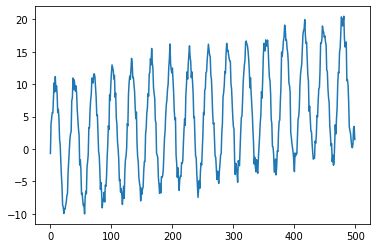

In [10]:
plt.plot(x,y)

In [18]:
# plitting the data in train and test
end_of_train = 300

x = np.expand_dims(x, axis=1)

x_train = x[:end_of_train]
x_test = x[end_of_train:]

y_train = y[:end_of_train]
y_test = y[end_of_train:]


In [19]:
print(x.shape)

(500, 1)


In [32]:
# Obtaining the predicted kernel hyper-parameters:

# TODO: print config to show it

# normalize x and y, AHGP will take in normalized x and y only
x_train_norm, x_test_norm, _, _ = standardize(x_train, x_test)
x_train_norm = x_train_norm*0.1
x_test_norm = x_test_norm*0.1
y_train_norm, mean_y_train, std_y_train = standardize(y_train)

# yaml config file of the AHGP model
model_config_filename = "./config/model.yaml"
# hyper_params are the hyperparameters of the spectral mixture product kernel
hyper_params = hyperparam(x_train_norm,y_train_norm,x_test_norm,model_config_filename,use_gpu=False)
print(hyper_params)  


RuntimeError: Error(s) in loading state_dict for GpSMDoubleAtt:
	Missing key(s) in state_dict: "filter_mu.0.linear_layer.weight", "filter_mu.0.linear_layer.bias", "filter_mu.1.linear_layer.weight", "filter_mu.1.linear_layer.bias", "filter_mu.2.linear_layer.weight", "filter_mu.2.linear_layer.bias". 

In [26]:
# We could rather use the found hyper-parameters in the GP:
mu_test, var_test = predict(x_train_norm,y_train_norm,x_test_norm,model_config_filename,use_gpu=False)

mu_test = mu_test * std_y_train + mean_y_train
var_test = var_test * std_y_train**2

rmse = np.mean((mu_test - y_test) ** 2) ** .5
log_likelihood = np.mean(np.log(stats.norm.pdf(
                          y_test,
                          loc=mu_test,
                          scale=var_test ** 0.5)))
print(rmse, log_likelihood)

8.336612331002033 -3.559503483842635


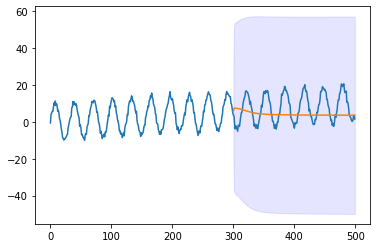

In [30]:
plt.plot(x,y)
plt.plot(x_test,mu_test)
plt.fill_between(x_test[:,0], (mu_test-var_test), (mu_test+var_test), color='b', alpha=.1)